<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_8_neural_networks_part2/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [115]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [160]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [117]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**

Чем больше размер батча, тем на меньшее количество батчей будет делиться датасет. Если размер батча будет сопоставим с размером датасета, то деление на батчи не будет эффективно. Слишком большой размер батча будет занимать память, и процесс обучения замедлится.

Посмотрим на какую-нибудь картинку:

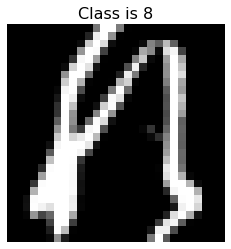

In [118]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





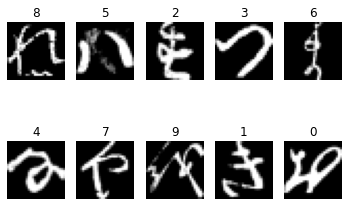

In [67]:
my_tags = []
f, axarr = plt.subplots(2,5) 

i = 0
j = 0
for image, tags in trainloader:
    for one_image, one_tag in zip(image, tags):
        if len(my_tags) == 10:
            break
        if one_tag not in my_tags:
            my_tags.append(one_tag)
 
            axarr[i,j].imshow(one_image.view(28, 28).numpy(), cmap="gray")
            axarr[i,j].axis('off')
            
            axarr[i,j].title.set_text(one_tag.item())

            j += 1
            if j == 5:
                i += 1
                j = 0   
    break
    
    

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [73]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        
        self.activation = nn.ReLU()

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        logits = self.fc3(x)

        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:** 28х28х256 + 256 + 256х128 + 128 + 128х10 + 10 = 235146

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [74]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [75]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [76]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE
#%%time

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.9183
Epoch=2 loss=0.4496
Epoch=3 loss=0.3543
Epoch=4 loss=0.2933
Epoch=5 loss=0.2503
Epoch=6 loss=0.2179
Epoch=7 loss=0.1902
Epoch=8 loss=0.1666
Epoch=9 loss=0.1469
Epoch=10 loss=0.1305


In [77]:
get_accuracy(fc_net, testloader)

0.879

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [169]:
def mean_std(dataset):
    images = [ image.numpy() for image, label in dataset ]
    imarr = np.array(images)

    mean, std = np.mean(imarr), np.std(imarr)
    return mean, std


mean, std = mean_std(trainset)
print(mean, std)

0.19176212 0.3483432


In [171]:
transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

In [172]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [173]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6954
Epoch=2 loss=0.3089
Epoch=3 loss=0.2274
Epoch=4 loss=0.1757
Epoch=5 loss=0.1405
Epoch=6 loss=0.1141
Epoch=7 loss=0.0939
Epoch=8 loss=0.0773
Epoch=9 loss=0.0625
Epoch=10 loss=0.0516


In [174]:
get_accuracy(fc_net, testloader)

0.8969

Как изменилась `accuracy` после нормализации?

Точность предсказания выросла с 87.9% до 89.7%, прирост 2%. К тому же, в процессе обучения уже в первой эпохе лосс был значительно ниже.

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [209]:
## YOUR CODE HERE
import torch.nn.functional as F

class FCNet_sigmoid(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        
        self.activation = nn.Sigmoid()

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        logits = self.fc3(x)

        return logits
    
class FCNet_GELU(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        
        self.activation = F.gelu

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        logits = self.fc3(x)

        return logits
    
class FCNet_tahn(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        
        self.activation = nn.Tanh()

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        logits = self.fc3(x)

        return logits

In [198]:
fc_net_sigmoid = FCNet_sigmoid()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net_sigmoid.parameters(), lr=3e-4)

In [215]:
n_epochs = 10
loss_history_sigmoid = []
print('Sigmoid activation')

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net_sigmoid(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history_sigmoid.append(epoch_loss/len(trainloader))

    
    print(f"Epoch={epoch+1} loss={loss_history_sigmoid[epoch]:.4f}")

Sigmoid activation
Epoch=1 loss=0.1692
Epoch=2 loss=0.1692
Epoch=3 loss=0.1692
Epoch=4 loss=0.1690
Epoch=5 loss=0.1691
Epoch=6 loss=0.1692
Epoch=7 loss=0.1691
Epoch=8 loss=0.1692
Epoch=9 loss=0.1691
Epoch=10 loss=0.1693


In [216]:
get_accuracy(fc_net_sigmoid, testloader)

0.8563

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

In [217]:
fc_net_GElu = FCNet_GELU()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net_GElu.parameters(), lr=3e-4)

In [218]:
n_epochs = 10
loss_history_gelu = []
print('GELU activation')

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net_GElu(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history_gelu.append(epoch_loss/len(trainloader))

    
    print(f"Epoch={epoch+1} loss={loss_history_gelu[epoch]:.4f}")

GELU activation
Epoch=1 loss=0.6632
Epoch=2 loss=0.2819
Epoch=3 loss=0.2032
Epoch=4 loss=0.1552
Epoch=5 loss=0.1220
Epoch=6 loss=0.0977
Epoch=7 loss=0.0790
Epoch=8 loss=0.0632
Epoch=9 loss=0.0506
Epoch=10 loss=0.0392


In [219]:
get_accuracy(fc_net_GElu, testloader)

0.9004

In [220]:
fc_net_tahn = FCNet_tahn()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net_tahn.parameters(), lr=3e-4)

In [221]:
n_epochs = 10
loss_history_tanh = []
print('Tanh activation')

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net_tahn(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history_tanh.append(epoch_loss/len(trainloader))

    
    print(f"Epoch={epoch+1} loss={loss_history_tanh[epoch]:.4f}")

Tanh activation
Epoch=1 loss=0.7779
Epoch=2 loss=0.3829
Epoch=3 loss=0.2597
Epoch=4 loss=0.1869
Epoch=5 loss=0.1382
Epoch=6 loss=0.1033
Epoch=7 loss=0.0784
Epoch=8 loss=0.0591
Epoch=9 loss=0.0434
Epoch=10 loss=0.0320


In [222]:
get_accuracy(fc_net_tahn, testloader)

0.8999

Наивысшую точность показал GELU,однако TANH совсем незначительно ниже.

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [223]:
fc_net_GElu = FCNet_GELU()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net_GElu.parameters(), lr=3e-4)

In [224]:
n_epochs = 10
loss_history_adam = []
print('Adam optimizer')

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net_GElu(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history_adam.append(epoch_loss/len(trainloader))

    
    print(f"Epoch={epoch+1} loss={loss_history_adam[epoch]:.4f}")

Adam optimizer
Epoch=1 loss=0.6550
Epoch=2 loss=0.2808
Epoch=3 loss=0.2043
Epoch=4 loss=0.1565
Epoch=5 loss=0.1227
Epoch=6 loss=0.0975
Epoch=7 loss=0.0777
Epoch=8 loss=0.0615
Epoch=9 loss=0.0495
Epoch=10 loss=0.0379


In [225]:
get_accuracy(fc_net_GElu, testloader)

0.8999

In [226]:
fc_net_RMSprop = FCNet_GELU()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.RMSprop(fc_net_RMSprop.parameters(), lr=3e-4)

In [227]:
n_epochs = 10
loss_history_RMSprop = []
print('RMSprop optimizer')

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net_RMSprop(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history_RMSprop.append(epoch_loss/len(trainloader))

    
    print(f"Epoch={epoch+1} loss={loss_history_RMSprop[epoch]:.4f}")

RMSprop optimizer
Epoch=1 loss=0.4395
Epoch=2 loss=0.2327
Epoch=3 loss=0.1703
Epoch=4 loss=0.1301
Epoch=5 loss=0.1024
Epoch=6 loss=0.0806
Epoch=7 loss=0.0638
Epoch=8 loss=0.0503
Epoch=9 loss=0.0389
Epoch=10 loss=0.0300


In [228]:
get_accuracy(fc_net_RMSprop, testloader)

0.9058

In [229]:
fc_net_Adagrad = FCNet_GELU()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adagrad(fc_net_Adagrad.parameters(), lr=3e-4)

In [230]:
n_epochs = 10
loss_history_Adagrad = []
print('Adagrad optimizer')

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net_Adagrad(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history_Adagrad.append(epoch_loss/len(trainloader))

    
    print(f"Epoch={epoch+1} loss={loss_history_Adagrad[epoch]:.4f}")

Adagrad optimizer
Epoch=1 loss=1.3365
Epoch=2 loss=0.8047
Epoch=3 loss=0.6848
Epoch=4 loss=0.6253
Epoch=5 loss=0.5877
Epoch=6 loss=0.5597
Epoch=7 loss=0.5378
Epoch=8 loss=0.5201
Epoch=9 loss=0.5056
Epoch=10 loss=0.4927


In [231]:
get_accuracy(fc_net_Adagrad, testloader)

0.7212

Лучше всего себя показал RMSprop.

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [255]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x
        x[x<0]=0
        
        return x
                

In [256]:
class FCNet_custom_relu(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        
        self.activation = CustomReLU()

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        logits = self.fc3(x)

        return logits

In [257]:
fc_net_custom_relu = FCNet_custom_relu()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.RMSprop(fc_net_custom_relu.parameters(), lr=3e-4)

In [258]:
n_epochs = 10
loss_history_custom_relu = []
print('Custom relu')

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net_custom_relu(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history_custom_relu.append(epoch_loss/len(trainloader))

    
    print(f"Epoch={epoch+1} loss={loss_history_custom_relu[epoch]:.4f}")

Custom relu
Epoch=1 loss=0.4691
Epoch=2 loss=0.2569
Epoch=3 loss=0.1933
Epoch=4 loss=0.1518
Epoch=5 loss=0.1200
Epoch=6 loss=0.0975
Epoch=7 loss=0.0780
Epoch=8 loss=0.0641
Epoch=9 loss=0.0505
Epoch=10 loss=0.0413


In [259]:
get_accuracy(fc_net_custom_relu, testloader)

0.8918

In [261]:
class FCNet_relu(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        
        self.activation = nn.ReLU()

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        logits = self.fc3(x)

        return logits

In [262]:
fc_net_relu = FCNet_relu()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.RMSprop(fc_net_relu.parameters(), lr=3e-4)

In [263]:
n_epochs = 10
loss_history_relu = []
print('relu')

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net_relu(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history_relu.append(epoch_loss/len(trainloader))

    
    print(f"Epoch={epoch+1} loss={loss_history_relu[epoch]:.4f}")

relu
Epoch=1 loss=0.4730
Epoch=2 loss=0.2627
Epoch=3 loss=0.1991
Epoch=4 loss=0.1567
Epoch=5 loss=0.1255
Epoch=6 loss=0.1012
Epoch=7 loss=0.0832
Epoch=8 loss=0.0665
Epoch=9 loss=0.0543
Epoch=10 loss=0.0435


In [264]:
get_accuracy(fc_net_relu, testloader)

0.8943

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

Всё работает, точность неодинаковая, но близкая.

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

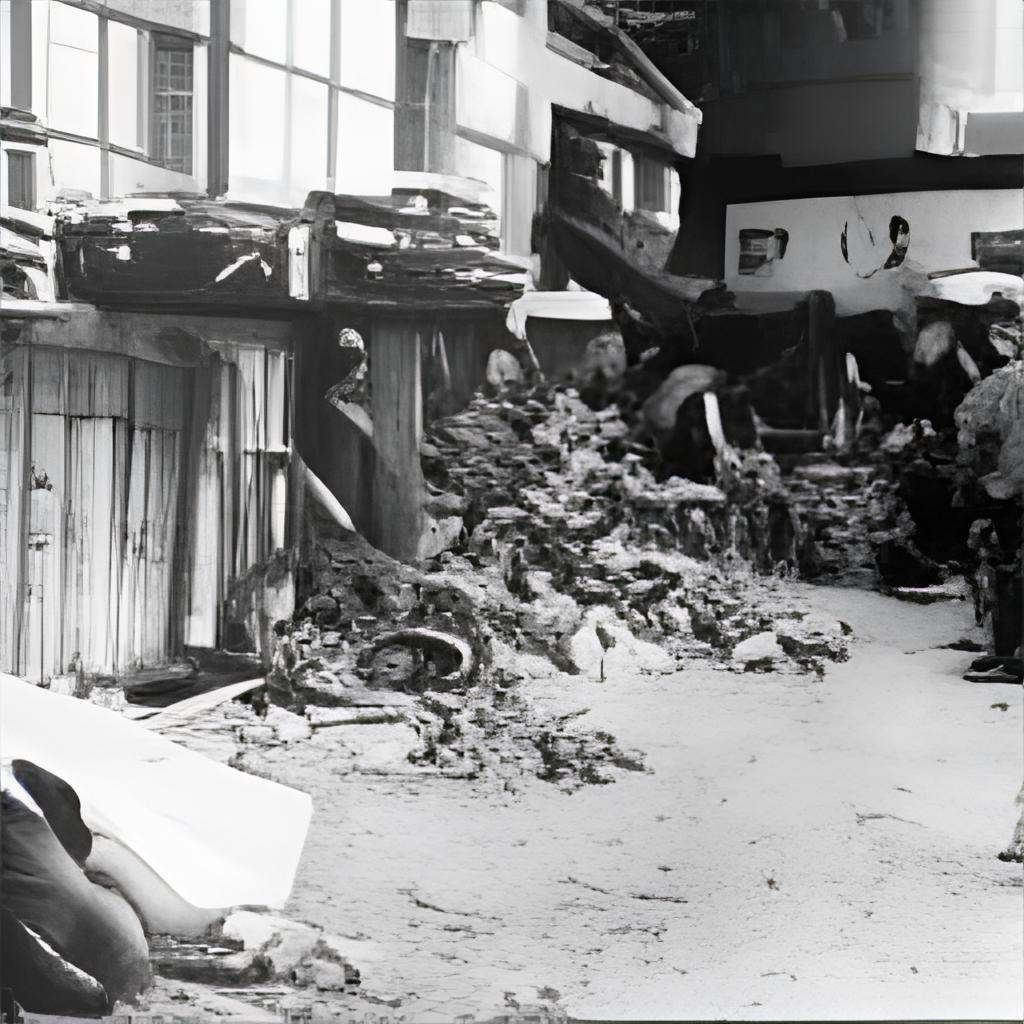

In [266]:
from IPython.display import Image
Image(filename='/home/alisa/Изображения/землетрясение.jpg') 

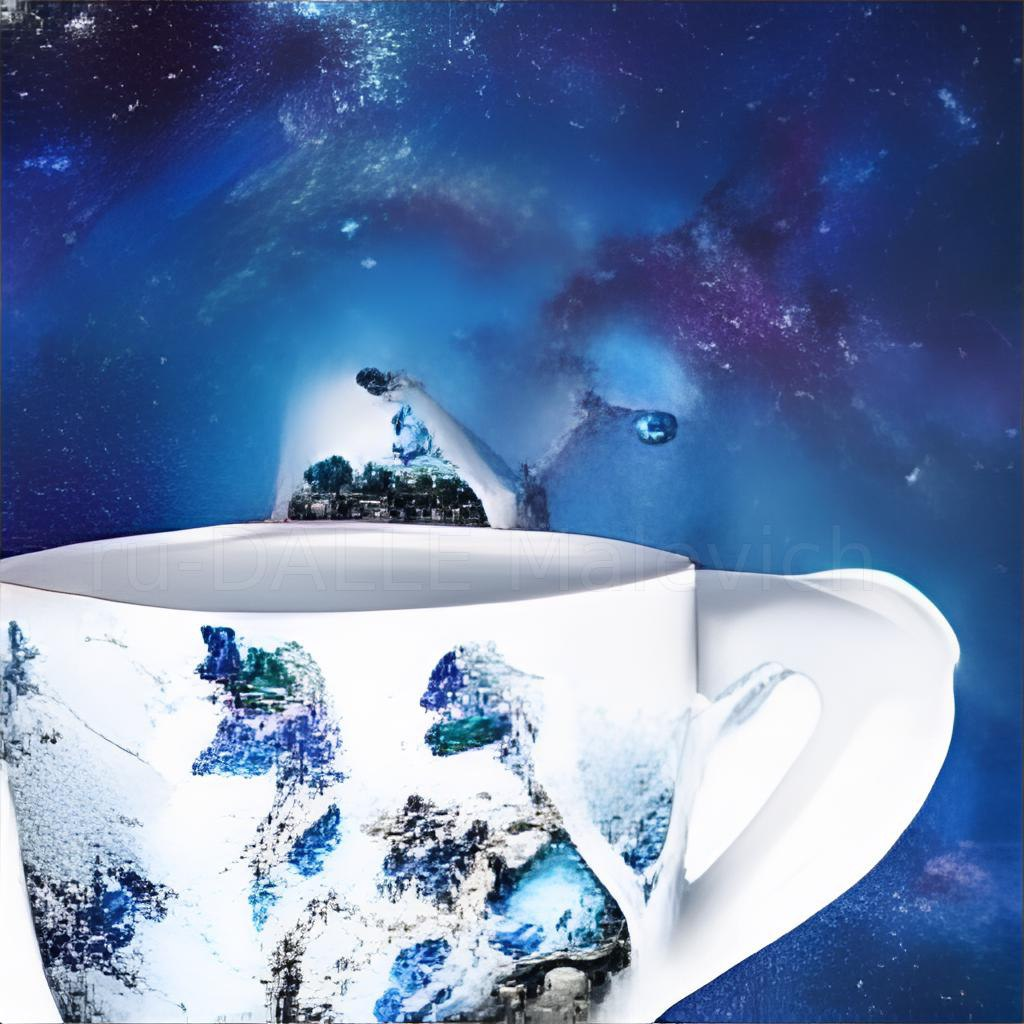

In [267]:
Image(filename='/home/alisa/Изображения/чашка_космоса.jpg') 

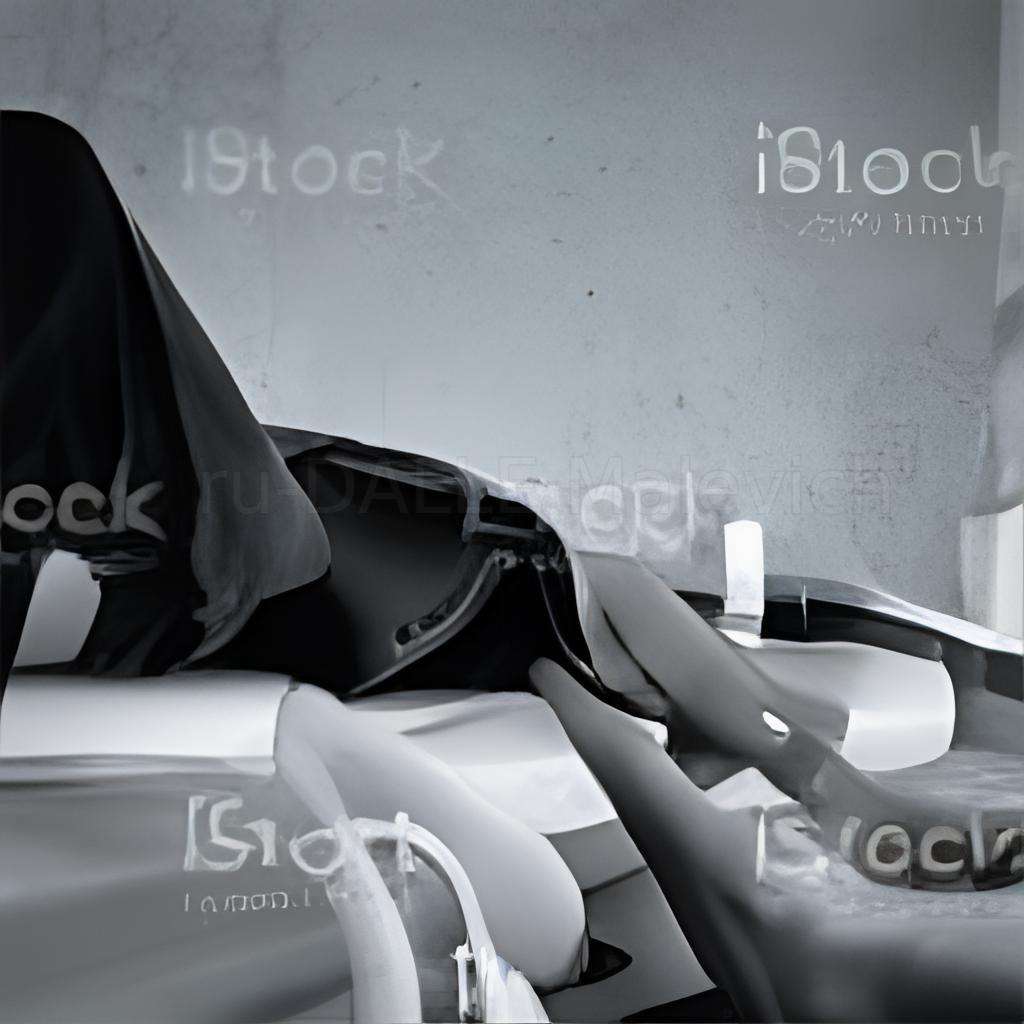

In [268]:
Image(filename='/home/alisa/Изображения/то_чего_не_может_быть.jpg') 